In [1]:
import re
import sys
import json


import sys
sys.dont_write_bytecode = True
sys.path.append('../')
from datatools.analyzer import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

In [3]:
path = "../../corpus/hand_labeled/"
datalist = ['DCM', 'DIT', 'IRS']
convs = read_conv(path, datalist)

In [4]:
def make_Xy(convs):
    X = []
    y = []
    for conv in convs:
        for i, ut in enumerate( conv ):
            if ut.is_utt_level_error():
                continue
            X.append(ut.utt)
            if ut.is_exist_type():
                y.append(1)
            else:
                y.append(0)
    return X, y

In [5]:
X, y = make_Xy(convs)

In [6]:
filler_func_ = lambda L: ["FOS",  *L, "EOS"]
def fill_SYMBOL_(L):
    return list(map(filler_func_, L))

def sentence2formated(sen):
    return sum( fill_SYMBOL_( sentence2normalize_noun(sen) ), [] )

In [7]:
from tqdm import tqdm
def make_vocab_dict(text):
    vocab_dict = dict()
    # doc = nlp(text)
    print("analyzed vocab text")
    vocab_dict["[PAD]"] = 0
    for key in tqdm(sentence2formated(text)):
        # key = token.orth_
        if key not in vocab_dict:
            vocab_dict[key] = len(vocab_dict)

    vocab_dict["[UNK]"] = len(vocab_dict)
    return vocab_dict

In [8]:
vocab_dict = make_vocab_dict(X)
vocab_size = len(vocab_dict)

analyzed vocab text


100%|██████████| 54396/54396 [00:00<00:00, 4372848.31it/s]


In [9]:
vocab_path = "../X_y_data/response2/"
vocab_name = "vocab_dict_noun.pickle"
vocabM = DataManager(vocab_path)
vocabM.save_data(vocab_name, vocab_dict)

success save : ../X_y_data/response2/vocab_dict_noun.pickle


In [10]:
vocab_path = "../X_y_data/response2/"
vocab_name = "vocab_dict_noun.pickle"
vocabM = DataManager(vocab_path)
vocab_dict = vocabM.load_data(vocab_name)

success load : ../X_y_data/response2/vocab_dict_noun.pickle


In [11]:
def sentence2ids(sentence:str, vocab_dict:dict):
    doc = sentence2formated(sentence)
    ids = np.zeros(len(doc))
    for i, key in enumerate(doc):
        # key = token.orth_
        if key in vocab_dict:
            ids[i] = vocab_dict[key]
        else:
            ids[i] = vocab_dict["[UNK]"]
    return ids

In [12]:
from tqdm import tqdm
import torch.nn.utils.rnn as rnn

def padding_vector(Xseq):
    Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
    Xseq = rnn.pad_sequence(Xseq, batch_first=True)
    Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
    return Xseq


def make_X(utt_list:list, vocab_dict:dict):
    utt_id_list = []
    for utt in tqdm( utt_list) :
        utt_id = sentence2ids(utt, vocab_dict)
        utt_id_list.append(utt_id)

    utt_id_pad = padding_vector(utt_id_list)
    upl = len(utt_id_pad[0])
    # X =   [ torch.Tensor([u, s]) for u, s in zip(usr_id_pad, sys_id_pad) ] 
    # print(usr_pad_len, sys_pad_len)
    X = torch.zeros( (len(utt_list), upl) )
    for i, u in enumerate(utt_id_pad):
        X[i, :upl] = u
    return X


In [13]:
X_= make_X(X,  vocab_dict)

100%|██████████| 3814/3814 [01:18<00:00, 48.47it/s]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.30, random_state=5, stratify=y)

In [15]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [59]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, tagset_size, vocab_dict):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.hidden2tag = nn.Linear(hidden_dim , tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax()
    
        self.vocab_dict = vocab_dict
    
    def forward(self, x):
        #embeds.sizea() = (batch_size × len(sentence) × embedding_dim)

        # x : [seq]
        # usr_ = x[:, :upl]
        # sys_ = x[:, upl:upl+spl]
        emb1 = self.word_embeddings(x)
        # emb2 = self.word_embeddings(sys_)
        _, lstm1_out = self.lstm1(emb1)
        # _, lstm2_out = self.lstm1(emb2)
        # print(hidden_layer)
        # bilstm_out = torch.cat([lstm_out[0][0], lstm_out[0][1]], dim=1)
        
        # usr_vec = ( lstm1_out[0][0] + lstm1_out[0][1] )
        # sys_vec = ( lstm2_out[0][0] + lstm2_out[0][1] )/2

        # print(usr_vec.shape, sys_vec.shape)
        # print(torch.cat([ usr_vec, sys_vec], dim=1).shape)
        tag_space = self.hidden2tag(torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 ))
        
        # y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))

        # y = self.hidden2tag(bilstm_out)
        y =self.softmax(tag_space)
        return y
    
    def last_context(self, x):
        emb1 = self.word_embeddings(x)
        # print(emb1.shape)
        _, lstm1_out = self.lstm1(emb1)
        context = torch.cat([ lstm1_out[0][0], lstm1_out[0][1]], dim=1 )
        return context
    
    def text2context(self, text):
        if isinstance(text, str):
            utt_id = self._sentence2ids(text, self.vocab_dict)
            utt_id_tensor = torch.tensor( [utt_id] , device='cuda:0', dtype=torch.int)
            # utt_id_tensor = torch.tensor( [utt_id] , device='cpu', dtype=torch.int)
            return self.last_context(utt_id_tensor)
        if isinstance(text, list):
            X = self._make_X(text, self.vocab_dict)
            utt_id_tensor = X.to(torch.int).cuda()
            # utt_id_tensor = X.to(torch.int)
            return self.last_context(utt_id_tensor)
        else:
            return 0

        
    def _sentence2ids(self, sentence:str, vocab_dict:dict):
        doc = self._sentence2formated(sentence)
        ids = np.zeros(len(doc))
        for i, key in enumerate(doc):
            # key = token.orth_
            if key in vocab_dict:
                ids[i] = vocab_dict[key]
            else:
                ids[i] = vocab_dict["[UNK]"]
        return ids
    
    def _sentence2formated(self, sen):
        return sum( fill_SYMBOL_ONE( sentence2normalize_noun(sen) ), [] )
    
    def _padding_vector(self, Xseq):
        Xseq = [ torch.tensor( xseq[:, None] ) for xseq in Xseq]
        Xseq = rnn.pad_sequence(Xseq, batch_first=True)
        Xseq = [ torch.flatten(xseq) for xseq in Xseq ] 
        return Xseq


    def _make_X(self, utt_list:list, vocab_dict:dict):
        utt_id_list = []
        for utt in tqdm( utt_list) :
            utt_id = self._sentence2ids(utt, vocab_dict)
            utt_id_list.append(utt_id)

        utt_id_pad = self._padding_vector(utt_id_list)
        upl = len(utt_id_pad[0])
        # X =   [ torch.Tensor([u, s]) for u, s in zip(usr_id_pad, sys_id_pad) ] 
        # print(usr_pad_len, sys_pad_len)
        X = torch.zeros( (len(utt_list), upl) )
        for i, u in enumerate(utt_id_pad):
            X[i, :upl] = u
        return X
        

In [60]:
BATCH_SIZE = 32
epoch_ = 300
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [61]:
VOCAB_SIZE = len(vocab_dict)
EMBEDDING_DIM = 128
HIDDEN_DIM = EMBEDDING_DIM*2
OUTPUT_DIM = 2

In [62]:
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, vocab_dict)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
text = ["あああ", "いいい"]
model.text2context(text).shape

100%|██████████| 2/2 [00:00<00:00, 51.77it/s]


torch.Size([2, 256])

In [64]:
losses = []
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        X_t_tensor = data[0].to(torch.int).cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape , y_t_tensor.view(-1,1).shape)

        score = model(X_t_tensor)
        # print(X_t_tensor.shape, score.view(-1,5).shape, y_t_tensor.view(-1,1).shape)
        loss_ = loss_function(score,  y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 50 	 loss 1.329736495101315
epoch 100 	 loss 1.1677136448615784
epoch 150 	 loss 1.174605282547418
epoch 200 	 loss 1.11150508863102
epoch 250 	 loss 1.1212896907391041


KeyboardInterrupt: 

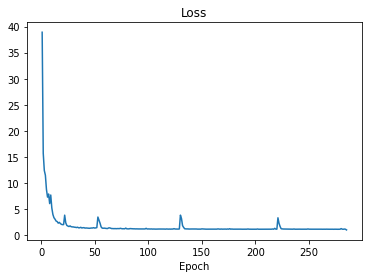

In [65]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [66]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0', dtype=torch.int)
    y_tensor = torch.tensor(y_test, device='cuda:0', dtype=torch.long)
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [67]:
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[828  27]
 [ 25 265]]
accuracy =  0.9545851528384279
precision =  0.9075342465753424
recall =  0.9137931034482759
f1 score =  0.9106529209621994


In [68]:
model_path = "../models/response2/"
model_name = "forward_v2.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

success save : ../models/response2/forward_v2.pickle
